In [ ]:
!pip install -U matplotlib
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

# Data Download

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /content/dat

# Dataset

## Data Preprocessing

In [ ]:
BATCH_SIZE = 32
TIME_STEPS = 1000
IM_SHAPE = (64,64,3)
N_HEADS = 8
ATTN_DIM = 256
N_GROUPS = 8
N_RESNETS = 2
LEARNING_RATE = 2e-4

In [ ]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=32
)

Found 202599 files belonging to 1 classes.


In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
def augmentation(image):
  return ...

In [ ]:
train_dataset = (
    ds_train
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

for d in train_dataset.take(1):
  print(d.shape)

(16, 64, 64, 3)


## Data Visualization

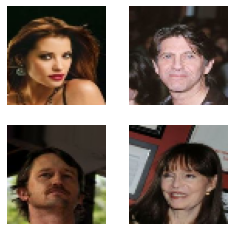

In [ ]:
plt.figure(figsize = (4,4))
k=0
n = 4
for i in range(n):
    ax = plt.subplot(2,2, k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis("off")
    k+=1

## Dataset Preparation

In [ ]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return tf.linspace(beta_start, beta_end, timesteps)

In [ ]:
# define beta schedule
betas = linear_beta_schedule(TIME_STEPS)

# define alphas 
alphas = 1. - betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)
alphas_cumprod_prev = tf.concat([tf.ones((1,)),alphas_cumprod[:-1]],axis = 0)
sqrt_recip_alphas = tf.math.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = tf.math.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
def extract(a, t, x_shape):
  b, *_ = t.shape
  out = tf.gather(a,t)
  output = tf.reshape(out, (b,*((1,) * (len(x_shape) - 1))))
  return output

In [ ]:
def q_sample(x_start, t, noise):

  sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(
      sqrt_one_minus_alphas_cumprod, t, x_start.shape
  )
  out_sample = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
  return out_sample

In [ ]:
x_start = d

t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS, dtype=tf.int32)
print(t)
print(x_start.shape, t.shape, )
sample = q_sample(x_start, t,tf.random.normal(x_start.shape))
print(sample.shape)

tf.Tensor([906  71 213  15 313 609 748 912 632  26 472   6  83  47 133 912], shape=(16,), dtype=int32)
(16, 64, 64, 3) (16,)
(16, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


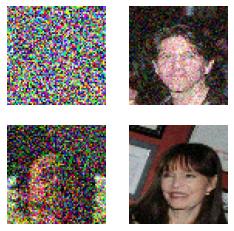

In [ ]:
plt.figure(figsize = (4,4))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((sample[i]+1)/2) 
  plt.axis("off")
  k+=1

# Modeling

## Positional Embeddings

In [ ]:
class PositionalEmbeddings(tf.keras.layers.Layer):

    def __init__(self, dim):
        super().__init__()
        self.embedding_dim = dim

    def get_timestep_embedding(self, timesteps, embedding_dim: int):
        """
        From Fairseq.
        Build sinusoidal embeddings.
        This matches the implementation in tensor2tensor, but differs slightly
        from the description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = self.embedding_dim // 2
        emb = tf.math.log(10000.) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, dtype = tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        if embedding_dim % 2 == 1:
            emb = tf.pad(emb, [[0, 0], [0, 1]])
        return emb

    def call(self, time):
        return self.get_timestep_embedding(time, self.embedding_dim)

## Residual Block

In [ ]:
def res_block(x,filters,n_groups,temb):
    previous = x
    x = Conv2D(filters, 3, padding="same",)(x) ### Convolution layer with padding same, so that the resolution remains the same
    
    ### temb represents the time embedding.
    ### It is passed into the silu activation function and a Dense Layer(Which can change the the embedding dimension )
    ### We also reshape the time embedding to match the output of 2d convnets.
    x += Dense(filters)(tf.nn.silu(temb))[:,None,None,:]
    
    ### Group Normalization is used.
    x = tf.nn.silu(tfa.layers.GroupNormalization(n_groups, axis = -1)(x))
    x = Conv2D(filters, 3, padding="same",)(x)

    # Project residual
    residual = Conv2D(filters, 1,padding="same",)(previous)
    x = tf.keras.layers.add([x, residual])  # Add back residual
    return x

## Unet Model

In [ ]:
def get_model(im_shape=(64,64,3),n_resnets=2,n_groups=8,attn_dim=32,n_heads=4,):
    input_1 = Input(shape=im_shape)### image input
    input_2 = Input(shape=())### time input
    t_dim = im_shape[0]*16

    # Entry block
    x = Conv2D(32, 3, padding="same")(input_1)
    temb = PositionalEmbeddings(t_dim)(input_2)### Create embeddings from the time input_2
    temb = Dense(t_dim)(tf.nn.gelu(Dense(t_dim)(temb)))### pass the embedding into the gelu activation function
    
    hs = [x]### variable used for storing each resolution level output, in the downward path, to be concatenated to the inputs of the upward path. 
    
    ### Downward Path
    for filters in [32, 64, 128, 256]:### for every resolution level (32,64,128,256), represent the depth they map to resolutions of (32,16,8,4)
        for _ in range(n_resnets):### we go through each resnet block per resolution level
            x = res_block(x,filters,n_groups,temb)### resblock
            ### if the resolution=16 (coinciding with a depth=64), we make the resnet output features attend to each other.
            ### Note how the attention axes = (1,2). This corresponds to the height and width dimensions.
            ### Feel free to Check the documentation out :) https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.
            ### query = key = value = x. 
            ### We again use Group Normalization.
            if filters == 64:
                x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
                    MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
        hs.append(x)### append the output features to hs
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)### Downsampling in order to move to the next resolution level

    
    ### Bottleneck
    x = res_block(x,256,n_groups,temb)
    x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
      MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
    x = res_block(x,256,n_groups,temb)

    
    ### Upward path
    for filters in [256, 128, 64,32]:
        ### we resize x, to match with the shape of feature outputs (hs) in the downward path
        x = tf.image.resize_with_pad(x,hs[-1].shape[1],hs[-1].shape[2])
        x = tf.concat([x,hs.pop()], axis=-1)
    
        for _ in range(n_resnets):
            x = res_block(x,filters,n_groups,temb)

            if filters == 64:
                x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
                  MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))

        if filters != 32:
            x = Conv2DTranspose(filters, 3, strides = (2,2),)(x)### Upsampling

    x = res_block(x,32,n_groups,temb)
    outputs = Conv2D(3, 3, padding="same", )(x)

    # Define the model
    model = Model([input_1,input_2], outputs,name='unet')
    return model

In [ ]:
# Build model
model= get_model(im_shape=IM_SHAPE,n_resnets=N_RESNETS,n_groups=N_GROUPS,attn_dim=ATTN_DIM,n_heads=N_HEADS,)
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 positional_embeddings (Positio  (None, 1024)        0           ['input_2[0][0]']                
 nalEmbeddings)                                                                                   
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['positional_embeddings[0][0]']  
                                                                                                  
 tf.nn.gelu (TFOpLambda)        (None, 1024)         0           ['dense_1[0][0]']             

In [ ]:
model.load_weights('/content/drive/MyDrive/Bang/unet')

# Training

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.5e-4)

In [ ]:
def custom_loss(denoise_model, x_start, t, noise=None):
  h = tf.keras.losses.Huber()
  noise = tf.random.normal(x_start.shape,mean=0,stddev=1)
  x_noisy = q_sample(x_start,t,noise)
  
  predicted_noise = denoise_model([x_noisy, t])

  # plt.figure(figsize = (10,10))
  # outs = [x_noisy,noise,predicted_noise]
  # print('predicted------------',predicted_noise)
  # print('actual -------------;',noise)
  # for i in range(3):
  #   ax = plt.subplot(1,3, i+1)
  #   plt.imshow(outs[i][10])
  #   plt.axis("off")

  return h(noise,predicted_noise)#tf.reduce_mean(tf.math.square(noise-predicted_noise))#

In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    
    t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS,dtype=tf.int32)
    loss = custom_loss(model,x_batch,t)

  partial_derivatives = recorder.gradient(loss, model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, model.trainable_weights))
  return loss

In [ ]:
def neuralearn(EPOCHS):
  for epoch in range(EPOCHS):
    init_time = time.time()
    losses = []
    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
      losses.append(loss)
      if step%500==0:
        print(step)
      
    print(str(epoch+1)+"/"+str(EPOCHS)+": Training Loss----->", sum(losses)/len(losses))
    print('Time Elapsed: ---> '+str(time.time()-init_time)+' s')
    model.save('/content/drive/MyDrive/Bang/unet')
    
  print("Training Complete!!!!")

In [ ]:
neuralearn(10)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
1/10: Training Loss-----> tf.Tensor(0.012256743, shape=(), dtype=float32)
Time Elapsed: ---> 7092.936837434769 s


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bang/unet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bang/unet/assets


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
2/10: Training Loss-----> tf.Tensor(0.012297407, shape=(), dtype=float32)
Time Elapsed: ---> 7082.153632640839 s


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bang/unet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bang/unet/assets


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
3/10: Training Loss-----> tf.Tensor(0.012213397, shape=(), dtype=float32)
Time Elapsed: ---> 7082.232358217239 s


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bang/unet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bang/unet/assets


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
4/10: Training Loss-----> tf.Tensor(0.012229529, shape=(), dtype=float32)
Time Elapsed: ---> 7082.220143556595 s


KeyboardInterrupt: ignored

# Testing :)

In [ ]:
#@tf.function
def p_sample(model, x, t, t_index):
  
  betas_t = extract(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
  sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
  
  model_mean = sqrt_recip_alphas_t * (x - betas_t * model([x, t]) / sqrt_one_minus_alphas_cumprod_t)

  if t_index == 0:
      return model_mean
  else:
      posterior_variance_t = extract(posterior_variance, t, x.shape)
      noise = tf.random.normal(x.shape)
      
      # Algorithm 2 line 4:
      return model_mean + tf.math.sqrt(posterior_variance_t) * noise

In [ ]:

imgs = []
img = tf.random.normal((64,IM_SHAPE[0],IM_SHAPE[1],IM_SHAPE[2]))
for i in reversed(range(0, TIME_STEPS)):
  print(i)
  img = p_sample(model,img,tf.fill((1,),i,), i)
  imgs.append(img)

999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750


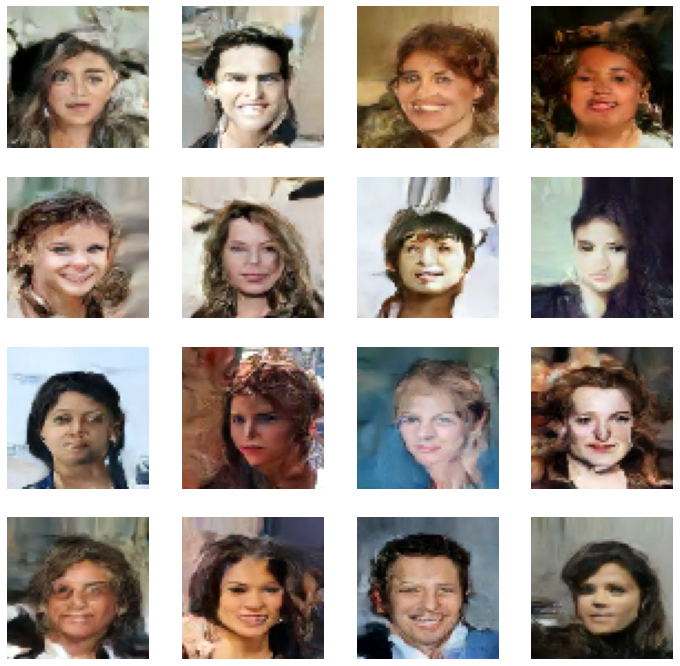

In [ ]:
plt.figure(figsize = (12,12))

for i in range(16):
  ax = plt.subplot(4,4, i+1)
  plt.imshow((np.array(imgs[999])[16+i]+1)/2)
  plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

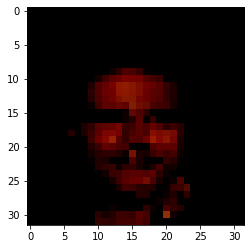

In [ ]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
for i in range(TIME_STEPS):
    im = plt.imshow(np.array(imgs[i])[random_index], animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()


In [ ]:
len(ims)

1000

# Model

In [ ]:

class PositionalEmbeddings(tf.keras.layers.Layer):

  def __init__(self, dim):
    super().__init__()
    self.embedding_dim = dim

  def get_timestep_embedding(self, timesteps, embedding_dim: int):
    """
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    half_dim = self.embedding_dim // 2
    emb = tf.math.log(10000.) / (half_dim - 1)
    emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
    emb = tf.cast(timesteps, dtype = tf.float32)[:, None] * emb[None, :]
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
    # if embedding_dim % 2 == 1:
    #   emb = tf.pad(emb, [[0, 0], [0, 1]])
    return emb

  def call(self, time):

    return self.get_timestep_embedding(time, self.embedding_dim)



In [ ]:

timesteps = 200
t = tf.random.uniform((BATCH_SIZE,), 0, timesteps, dtype = tf.int32 )

pos = PositionalEmbeddings(256)
print(pos(t))

tf.Tensor(
[[ 0.9802397  -0.9856166   0.98930377 ...  0.99986905  0.9998867
   0.999902  ]
 [-0.7568025  -0.5468414  -0.31299213 ...  0.9999999   0.9999999
   0.99999994]
 [-0.88179886  0.27157855  0.6098344  ...  0.99973536  0.9997711
   0.999802  ]
 ...
 [-0.91652155  0.97844124 -0.97986823 ...  0.9999882   0.9999898
   0.9999912 ]
 [-0.35493836  0.48132214  0.41464454 ...  0.99975365  0.9997869
   0.9998157 ]
 [ 0.42016706 -0.458038   -0.96910685 ...  0.99999887  0.99999905
   0.99999917]], shape=(32, 256), dtype=float32)


## Convert TO GIF

In [ ]:
import matplotlib.animation as animation

random_index = 7

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(np.array(imgs[i])[random_index][...,0], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()
